<CENTER><img src="images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

This analysis loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 5 and 5.1)

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/Hyy_feynman.png" style="width:40%"></CENTER>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on binder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib lmfit --user # install required packages

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [1]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks

<a id='fraction'></a>

General definitions of luminosity, fraction of data used, where to access the input files

In [2]:
lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
#lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.8 # reduce this is you want the code to run quicker

tuple_path = "Input/GamGam/Data/" # local 
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

<a id='samples'></a>

Samples to process.

In [3]:
samples_list = ['data_A'] # 'data_B','data_C','data_D'


Define function to get data from files

In [4]:
def get_data_from_files():

    frames = [] # define empty list to hold data
    for val in samples_list: # loop over each file
        fileString = tuple_path+val+".GamGam.root" # file name to open
        temp = read_file(fileString,val) # call the function read_file defined below
        frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data = pd.concat(frames) # concatenate list of dataframes together into one dataframe
    
    return data # return dataframe

Define function to calculate diphoton invariant mass

In [5]:
def calc_myy(photon_pt,photon_eta,photon_phi,photon_E):
    # first photon is [0], 2nd photon is [1] etc
    px_0 = photon_pt[0]*math.cos(photon_phi[0]) # x-component of photon[0] momentum
    py_0 = photon_pt[0]*math.sin(photon_phi[0]) # y-component of photon[0] momentum
    pz_0 = photon_pt[0]*math.sinh(photon_eta[0]) # z-component of photon[0] momentum
    px_1 = photon_pt[1]*math.cos(photon_phi[1]) # x-component of photon[1] momentum
    py_1 = photon_pt[1]*math.sin(photon_phi[1]) # y-component of photon[1] momentum
    pz_1 = photon_pt[1]*math.sinh(photon_eta[1]) # z-component of photon[1] momentum
    sumpx = px_0 + px_1 # x-component of diphoton momentum
    sumpy = py_0 + py_1 # y-component of diphoton momentum
    sumpz = pz_0 + pz_1 # z-component of diphoton momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of diphoton momentum 
    sumE = photon_E[0] + photon_E[1] # energy of diphoton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "Applying a cut" cell.

In [6]:
# Cut on photon reconstruction quality
# paper: "Photon candidates are required to pass identification criteria"
def cut_photon_reconstruction(photon_isTightID):
# isTightID==True means a photon identified as being well reconstructed
# want to keep events where True for both photons
# first photon is [0], 2nd photon is [1] etc
    return photon_isTightID[0]==True and photon_isTightID[1]==True
    
# Cut on Transverse momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def cut_photon_pt(photon_pt):
# want to keep events where photon_pt[0]>40000 MeV and photon_pt[1]>30000 MeV
    return photon_pt[0]>40000 and photon_pt[1]>30000

# Cut on energy isolation
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def cut_isolation_et(photon_etcone20):
# want to keep events where isolation eT<4000 MeV
    return photon_etcone20[0]<4000 and photon_etcone20[1]<4000

# Cut on pseudorapidity in barrel/end-cap transition region
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52"
def cut_photon_eta_transition(photon_eta):
# want to keep events where modulus of photon_eta is outside the range 1.37 to 1.52
    return (abs(photon_eta[0])>1.52 or abs(photon_eta[0])<1.37) and (abs(photon_eta[1])>1.52 or abs(photon_eta[1])<1.37)


<a id='applying_cut'></a>

## Applying a cut 

If you add a cut: Cell -> Run All Below

In [7]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("Processing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path)["mini"] # open the tree called mini
    numevents = uproot.numentries(path, "mini") # number of events
    for data in tree.iterate(["photon_n","photon_pt","photon_eta",
                              "photon_phi","photon_E",
                              "photon_isTightID","photon_etcone20"], # add more variables here if you want to use them
                             entrysteps=2500000, # number of events in a batch to process
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        
        # Cut on photon reconstruction quality using the function cut_photon_reconstruction defined above
        data = data[ np.vectorize(cut_photon_reconstruction)
                    (data.photon_isTightID) ]
        
        # Cut on transverse momentum of the photons using the function cut_photon_pt defined above
        data = data[ np.vectorize(cut_photon_pt)
                    (data.photon_pt) ]
        
        # Cut on energy isolation using the function cut_isolation_et defined above
        data = data[ np.vectorize(cut_isolation_et)
                    (data.photon_etcone20) ]
        
        # Cut on pseudorapidity inside barrel/end-cap transition region using the function cut_photon_eta_transition
        data = data[ np.vectorize(cut_photon_eta_transition)
                    (data.photon_eta) ]
        
        # Calculate reconstructed diphoton invariant mass using the function calc_myy defined above
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt,
                                             data.photon_eta,
                                             data.photon_phi,
                                             data.photon_E)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['photon_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['photon_pt','photon_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

This is where the processing happens

In [8]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing: data_A
	 nIn: 344275,	 nOut: 	17799	 in 6.1s
Time taken: 6.6s


<a id='plotting'></a>

Let's take a look at the data before plotting

In [9]:
print(data)

        photon_n               photon_pt                 photon_eta  \
entry                                                                 
10             2  [176121.16, 39629.145]    [-0.833492, 0.09470307]   
11             2   [100427.68, 95522.57]     [1.7343543, 0.6880436]   
76             2  [45906.086, 34899.742]   [0.5604442, -0.18553612]   
86             2    [78156.23, 66979.34]    [0.22070466, 1.0673687]   
106            2   [59702.844, 36279.23]   [-0.4967246, 0.94473416]   
...          ...                     ...                        ...   
344161         2   [52634.152, 50902.86]   [-0.2772383, -2.0303562]   
344167         2  [51201.562, 43307.074]  [0.18128239, -0.29790884]   
344218         2   [68006.88, 51736.074]     [1.7892815, 0.8145695]   
344238         2  [109065.445, 34726.57]  [-2.2248409, -0.52343005]   
344253         2     [58356.32, 51646.8]     [1.3440994, 1.1279274]   

                        photon_phi                photon_E photon_isTightID 

The diphoton invariant mass can be accessed like:

In [10]:
print(data['myy'])

entry
10        106.420735
11        223.294982
76         85.259539
86        157.806521
106       116.489308
             ...    
344161    145.643472
344167     94.237343
344218    119.408772
344238    170.359919
344253     11.895109
Name: myy, Length: 17799, dtype: float64


## Plotting

In [12]:
xmin = 100 # GeV
xmax = 160 # GeV
step_size = 2 # GeV

bin_edges = np.arange(start=xmin, # The interval includes this value
                 stop=xmax+step_size, # The interval doesn't include this value
                 step=step_size ) # Spacing between values

bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values


Let's take a look at the array of bin edges

In [13]:
print(type(bin_edges))
print(bin_edges)

<class 'numpy.ndarray'>
[100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134
 136 138 140 142 144 146 148 150 152 154 156 158 160]


Define function to plot the data.

In [14]:
def plot_data(data):   
    
    #####################
    # Filling a histogram
    # For you to complete
    # Complete the lines below then uncomment them 
    #data_x,_ = np.histogram( ?diphoton invariant mass values?,
    #                        bins= ?array of bin edges? )
    data_x,_ = np.histogram( data['myy'], 
                            bins=bin_edges )
    # For you to complete
    #####################
    
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    #####################
    # Plot the data points
    # Complete the 2 lines below then uncomment them
    #plt.errorbar(x= ?array of bin centres?,
    #            y= ?the histogrammed data you defined in the earlier step?,
    #            yerr= ?the errors on the histogrammed data defined for you in the line above?,
    #            label= ?what label should this have in the legend?,
    #            fmt='ko') # 'k' means black and 'o' means circles
    plt.errorbar(x=bin_centres, 
                 y=data_x, 
                 yerr=data_x_errors,
                 label='Data',
                 fmt='ko' ) # 'k' means black and 'o' means circles
    # For you to complete
    #####################
    
    # data fit
    polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
    gaussian_mod = GaussianModel() # Gaussian
    # set initial guesses for the parameters of the polynomial model
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0=data_x.max(), c1=0, c2=0, c3=0, c4=0 )
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=91.7, center=125., sigma=2.4 )
    model = polynomial_mod + gaussian_mod # combined model
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors ) # fit the model to the data

    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    # get the background only part of the fit to data
    background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

    signal_x = data_x - background # data fit - background fit = signal fit
     
    # plot the signal + background fit
    plt.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )
    # plot the background only fit
    plt.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label='Bkg (4th order polynomial)' )

    plt.ylabel( 'Events' ) # write y-axis label for main axes
    plt.ylim( bottom=0 ) # set the y axis limit for the main axes
    plt.xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]') # x-axis label
    
    # draw the legend
    plt.legend( frameon=False ) # no box around the legend
    
    print('chi^2 = '+str(out.chisqr))
    print('gaussian centre = '+str(params_dict['center']))
    print('gaussian sigma = '+str(params_dict['sigma']))
    print('gaussian fwhm = '+str(params_dict['fwhm']))
    
    return

Call the function to plot the data

chi^2 = 20.581065855599388
gaussian centre = 125.99139013786059
gaussian sigma = 0.41429537330863764
gaussian fwhm = 0.9755910309746462


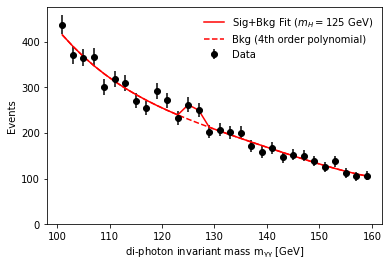

In [15]:
plot_data(data)

## What can you do to explore this analysis?

* Increase the fraction of data used [here](#fraction)
* Use data_B, data_C and data_D [here](#samples) and see intstructions below
* Try different initial guesses for the parameters of the fit in '[Plotting](#plotting)'
* Try different functions for the fit in '[Plotting](#plotting)'
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0090) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Add some extra commands in '[Plotting](#plotting)' to make it look more similar to the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0040)
* Your idea!

You can download more data by clicking on: 
* https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root
* https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root
* https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root

To use these extra data you'll also need to download this code that you're using to your computer. To do this you can follow the instructions [here](https://github.com/meevans1/how-to-rediscover-the-higgs-with-photons#get-started-on-your-own-laptop) and moving the extra downloaded data to Input/GamGam/Data/